Projet ML (core) : prédire la réadmission à l’hôpital d'un patient diabétique sous 30 jours

In [2]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind

# Configuration des graphiques
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# importation du fichier csv
from google.colab import files
uploaded = files.upload()

Saving diabetic_data.csv to diabetic_data.csv


In [4]:
#chargement des données
import pandas as pd

df = pd.read_csv('diabetic_data.csv')

#Apercu des premères lignes
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
print("Colonnes existantes dans le dataset :", df.columns)

Colonnes existantes dans le dataset : Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [6]:
df = df.drop(columns=[
    'encounter_id', 'patient_nbr',   # IDs
    'weight', 'payer_code', 'medical_specialty',  # Trop de valeurs manquantes

    # Médicaments très rares / inutilisables
    'acetohexamide', 'tolbutamide', 'chlorpropamide', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton',
    'glimepiride-pioglitazone', 'glipizide-metformin',
    'glyburide-metformin', 'metformin-pioglitazone', 'metformin-rosiglitazone',

    # Colonnes pouvant causer du data leakage
    'change',  # Indique changement de traitement durant le séjour
    'discharge_disposition_id'  # Peut indiquer si le patient est décédé → fuite de données
])
print("Colonnes restantes dans le dataset :", df.columns)


Colonnes restantes dans le dataset : Index(['race', 'gender', 'age', 'admission_type_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'diabetesMed',
       'readmitted'],
      dtype='object')


In [7]:
# Dimensions et types de colonnes
print("Dimensions :", df.shape)
print("\nTypes des colonnes :")
print(df.dtypes)

# Valeurs manquantes
df.isnull().sum().sort_values(ascending=False)

Dimensions : (101766, 31)

Types des colonnes :
race                   object
gender                 object
age                    object
admission_type_id       int64
admission_source_id     int64
time_in_hospital        int64
num_lab_procedures      int64
num_procedures          int64
num_medications         int64
number_outpatient       int64
number_emergency        int64
number_inpatient        int64
diag_1                 object
diag_2                 object
diag_3                 object
number_diagnoses        int64
max_glu_serum          object
A1Cresult              object
metformin              object
repaglinide            object
nateglinide            object
glimepiride            object
glipizide              object
glyburide              object
pioglitazone           object
rosiglitazone          object
acarbose               object
miglitol               object
insulin                object
diabetesMed            object
readmitted             object
dtype: object


,0
max_glu_serum,96420
A1Cresult,84748
race,0
admission_type_id,0
admission_source_id,0
gender,0
age,0
num_procedures,0
num_medications,0
number_outpatient,0


In [8]:
print(df['max_glu_serum'].value_counts(dropna=False))
print(df['A1Cresult'].value_counts(dropna=False))


max_glu_serum
NaN     96420
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64
A1Cresult
NaN     84748
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64


In [9]:
# Mapper les valeurs en entiers ordonnés
max_glu_serum_map = {
    np.nan: 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
}

a1c_result_map = {
    np.nan: 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
}

df['max_glu_serum'] = df['max_glu_serum'].map(max_glu_serum_map)
df['A1Cresult'] = df['A1Cresult'].map(a1c_result_map)


In [10]:
df['max_glu_serum'].replace('None', np.nan, inplace=True)
df['A1Cresult'].replace('None', np.nan, inplace=True)


/tmp/ipython-input-529187944.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['max_glu_serum'].replace('None', np.nan, inplace=True)
/tmp/ipython-input-529187944.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [11]:
print(df['max_glu_serum'].value_counts())
print(df['A1Cresult'].value_counts())


max_glu_serum
0    96420
1     2597
2     1485
3     1264
Name: count, dtype: int64
A1Cresult
0    84748
3     8216
1     4990
2     3812
Name: count, dtype: int64


In [12]:
# Suppression des doublons
df = df.drop_duplicates()

# Remplacement des '?' par NaN
df.replace('?', pd.NA, inplace=True)

# Imputation des valeurs manquantes -> Sépare les colonnes du dataframe en deux groupes :num_cols = colonnes numériques (âge, durée d’hospitalisation, etc.) et cat_cols = colonnes catégorielles (sexe, diagnostic, etc.)
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

# Imputation des colonnes numériques par la médiane -> Remplace les valeurs manquantes (NaN) dans les colonnes numériques par la médiane de la colonne
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Imputation des colonnes catégorielles par la valeur la plus fréquente (mode) -> Remplace les valeurs manquantes dans les colonnes catégorielles par la modalité la plus fréquente (mode)
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [13]:
# Création de la variable cible : 1 = réadmis dans les 30 jours, sinon 0
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Répartition des classes
df['readmitted_binary'].value_counts()

,count
readmitted_binary,
0,90409
1,11357


In [14]:
# Préparation des features X et de la cible y

# Séparer X (features) et y (target)
X = df.drop(columns=['readmitted', 'readmitted_binary'])
y = df['readmitted_binary']

# Encodage des variables catégorielles
X = pd.get_dummies(X, drop_first=True)

# Nettoyage des noms de colonnes (pour XGBoost notamment)
import re
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

# Vérification des dimensions
print("Shape X :", X.shape)
print("Shape y :", y.shape)


Shape X : (101766, 2311)
Shape y : (101766,)


101 766 exemples (lignes)
2311 features (colonnes) après encodage = élevé

X = Features (variables explicatives) => toutes les colonnes sauf la cible
y = Target (variable cible) => ce qu'on veut que le modèle prédise

In [15]:
# Séparation des données en train et test
from sklearn.model_selection import train_test_split

# Séparer en 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set :", X_train.shape)
print("Test set  :", X_test.shape)

Train set : (81412, 2311)
Test set  : (20354, 2311)


Train set (X_train, y_train) = Sert à entraîner le modèle.
Il apprend à "relier" les entrées (X) à la sortie (y).

Test set (X_test, y_test) = Sert à évaluer la performance réelle du modèle sur des données jamais vues.



In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Logistic Regression (avec standardisation)
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]


In [19]:
# Evaluation des modèles
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n Évaluation du modèle : {name}")
    print(classification_report(y_true, y_pred))
    print(f"AUC : {roc_auc_score(y_true, y_proba):.4f}")

evaluate_model("Logistic Regression", y_test, y_pred_log, y_proba_log)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)


 Évaluation du modèle : Logistic Regression
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.44      0.03      0.05      2271

    accuracy                           0.89     20354
   macro avg       0.66      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354

AUC : 0.6345

 Évaluation du modèle : Random Forest
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.57      0.01      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.73      0.50      0.48     20354
weighted avg       0.85      0.89      0.84     20354

AUC : 0.6280

 Évaluation du modèle : XGBoost
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.53      0.02      0.03      2271

    accuracy                           

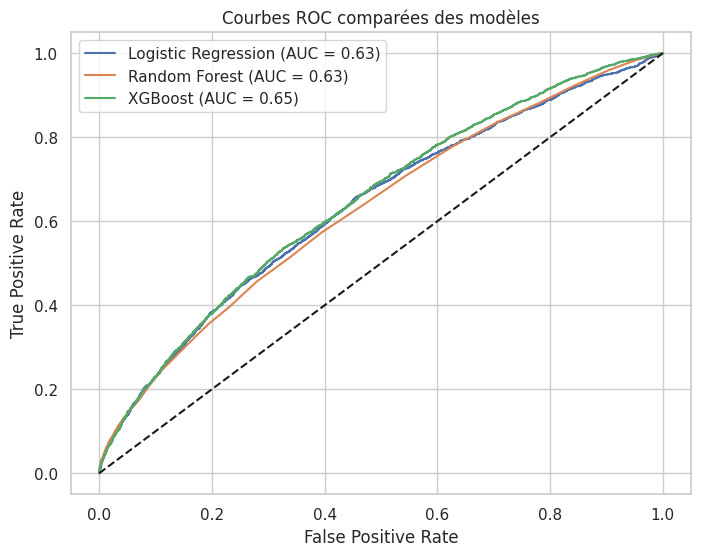

In [20]:
# Tracer les courbes ROC comparées
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(model_name, y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

plt.figure(figsize=(8, 6))
plot_roc("Logistic Regression", y_test, y_proba_log)
plot_roc("Random Forest", y_test, y_proba_rf)
plot_roc("XGBoost", y_test, y_proba_xgb)

plt.plot([0, 1], [0, 1], 'k--')  # Baseline hasard
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC comparées des modèles")
plt.legend()
plt.grid(True)
plt.show()

le modèle a 63 % de chances de classer un cas positif avant un cas négatif,

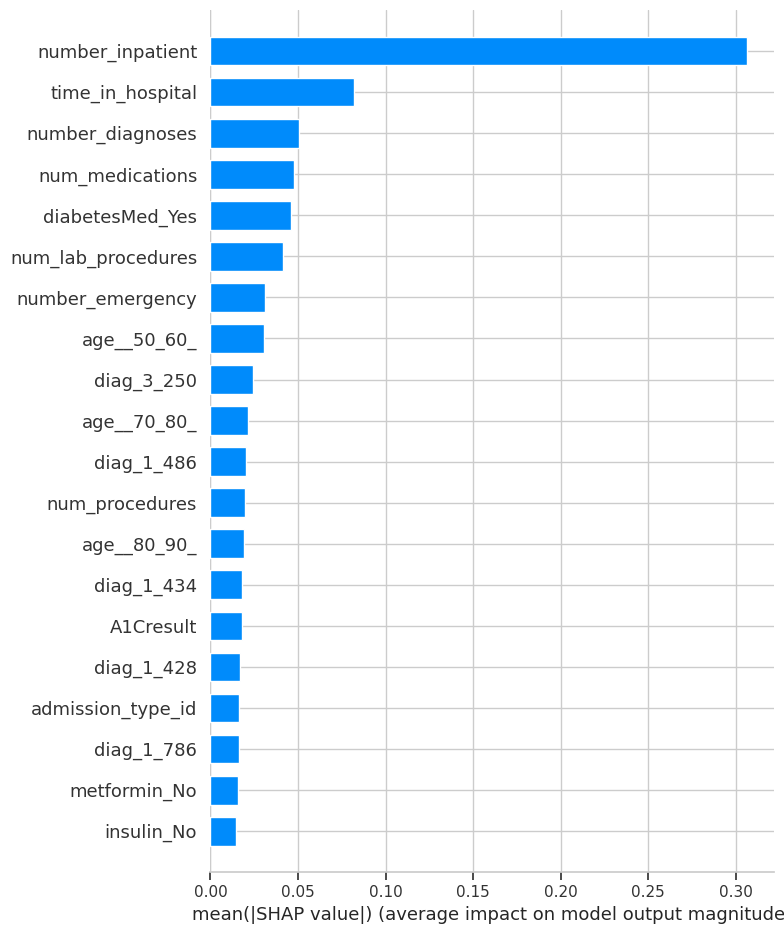

In [21]:
# Interprétation du modèle XGBoost avec SHAP
# Installer SHAP si besoin
!pip install shap --quiet

import shap

# Créer un explainer SHAP pour XGBoost
explainer = shap.Explainer(xgb)

# Adapter la taille de l'échantillon à la taille du jeu de test
sample_size = min(1000, X_test.shape[0])
sample_X = X_test.sample(sample_size, random_state=42)

# Calculer les valeurs SHAP
shap_values = explainer(sample_X)

# Affichage du résumé global des features importantes
shap.summary_plot(shap_values, sample_X, plot_type="bar")